#  A Simplistic Market Making Model

In this project, I would like to go over how to build a simplistic Market Making Model to deploy in an Algorithmic Trading context. The code does not contain Reinforcement Learning methods, however it shed some light over how Reinforcement Learning (and Temporal-difference (TD) learning) could help in better train our raw model.

## Sections:


### Introduction on Reinforcement Learning

Reinforcement learning (RL) is an interdisciplinary area of machine learning and optimal control concerned with how an intelligent agent should take actions in a dynamic environment in order to maximize a reward signal. Reinforcement learning is one of the three basic machine learning paradigms, alongside supervised learning and unsupervised learning. The environment is typically stated in the form of a Markov decision process (MDP), as many reinforcement learning algorithms use dynamic programming techniques. The main difference between classical dynamic programming methods and reinforcement learning algorithms is that the latter do not assume knowledge of an exact mathematical model of the Markov decision process, and they target large MDPs where exact methods become infeasible, hence the Machine Learning context.


Basic reinforcement learning is modeled as a Markov decision process:

- A set of environment and agent states (the state space), ${\displaystyle {\mathcal {S}}}$:


- ${\displaystyle P_{a}(s,s')=\Pr(S_{t+1}=s'\mid S_{t}=s,A_{t}=a)}$, the transition probability (at time ${\displaystyle t}$) from state ${\displaystyle s}$ to state ${\displaystyle s'}$ under action ${\displaystyle a}$.

- ${\displaystyle R_{a}(s,s')}$, the immediate reward after transition from ${\displaystyle s}$ to ${\displaystyle s'}$ under action ${\displaystyle a}$.


From a Machine Learning standpoint, most of the problems in the fields can be posed as optimisation problems.

We define a loss function $\mathcal{L} : (x, F_w) → \mathbb{R}$
- where $x$ is some data, and $F_w$ is an arbitrary stochastic continuous function parameterised by numeric weights $w$.
- $F$ is often non-linear.
- We minimise the expected loss by choosing appropriate weights: $ argmin _w \mathbb{E}[\mathcal{L}(x, F_w)] $

I also would like to go over Control Theory and specifically Stochastic Optimal Control, which would be essential to fit in our Market Making landscape. 


### Control Theory

Optimal control theory is a branch of control theory that deals with finding a control for a dynamical system over a period of time such that an objective function is optimized. Optimal control is an extension of the calculus of variations, and is a mathematical optimization method for deriving control policies. The method is largely due to the work of Lev Pontryagin and Richard Bellman in the 1950s, after contributions to calculus of variations by Edward J. McShane. Optimal control can be seen as a control strategy in control theory.

Optimal control deals with the problem of finding a control law for a given system such that a certain optimality criterion is achieved. A control problem includes a cost functional that is a function of state and control variables. An optimal control is a set of differential equations describing the paths of the control variables that minimize the cost function. The optimal control can be derived by solving the famous  Hamilton–Jacobi–Bellman equation (a sufficient condition).

In Stochastic Optimal Control problems, a sub-field of Optimal Control, the problems to be solved are in the universe of Stochastic Processes and therefore deal with the existence of uncertainty either in observations or in the noise that drives the evolution of the system. We assume, in a Bayesian probability-driven fashion, that random noise with known probability distribution affects the evolution and observation of the state variables. Stochastic control aims to design the time path of the controlled variables that performs the desired control task with minimum cost, somehow defined, despite the presence of this noise. The context may be either discrete time or continuous time.

An extremely well-studied formulation in stochastic control is that of linear quadratic Gaussian control. Here the model is linear, the objective function is the expected value of a quadratic form, and the disturbances are purely additive.

In a Linear discrete-time stochastic quadratic control problem, we would like to minimize:

${\displaystyle \mathbb {E} _{1}\sum _{t=1}^{S}\left[y_{t}^{\mathsf {T}}Qy_{t}+u_{t}^{\mathsf {T}}Ru_{t}\right]}$

where ${\displaystyle \mathbb {E}}$ is the expected value operator conditional on $y_0$,  S is the time horizon, subject to the state equation:

- ${\displaystyle y_{t}=A_{t}y_{t-1}+B_{t}u_{t},}$

where $y$ is an n × 1 vector of observable state variables, $u$ is a k × 1 vector of control variables, $A_t$ is the time $t$ realization of the stochastic n × n state transition matrix, $B_t$ is the time t realization of the stochastic n × k matrix of control multipliers, and $Q$ (n × n) and $R$ (k × k) are known symmetric positive definite cost matrices.


In a continuous setting, one of the method to attack an Optimal Control problem could be to solve the Hamilton-Jacobi-Bellman Equation.

### The Hamilton-Jacobi-Bellman Equation

The Hamilton-Jacobi-Bellman (HJB) equation is a nonlinear partial differential equation that provides necessary and sufficient conditions for optimality of a control with respect to a loss function. Its solution is the value function of the optimal control problem which, once known, can be used to obtain the optimal control by taking the maximizer (or minimizer) of the Hamiltonian involved in the HJB equation.

We present the HJB equation in a continuous deterministic setting:

${\displaystyle {\frac {\partial V(x,t)}{\partial t}}+\min _{u}\left\{{\frac {\partial V(x,t)}{\partial x}}\cdot F(x,u)+C(x,u)\right\}=0}$

When it comes to extending the problem in a stochastic setting, we would have to consider the below:

${\displaystyle \min _{u}\mathbb {E} \left\{\int _{0}^{T}C(t,X_{t},u_{t})\,dt+D(X_{T})\right\}}$


with:

- ${\displaystyle (X_{t})_{t\in [0,T]}}$ the stochastic process to optimize and
- $ {\displaystyle (u_{t})_{t\in [0,T]}}$ the steering.


Without focussing extensively on the various aspects of an Optimal Control problem, and their Stochastic counterpart, I would like to dive into the Settings for our simple Market Making model, and apply the Reinforcement Learning methodologies in order to find the optimal policies that we aim to identify. 

### Reinforcement Learning and Stochastic Control Problems

Reinforcement learning is technique for solving stochastic control problems. As defined previously, $F_w$ is an arbitrary stochastic continuous function parameterised by numeric weights $w$, often non-linear, which defines a (stochastic) mapping between states of the world, and corresponding
actions to take. The weights w typically specify propensities or probabilities for each action in each state. 

In the context of reinforcement-learning, we refer to the function F as a control policy. The loss function is the negative of the stochastic return obtained by taking the resulting actions. In contrast to traditional stochastic control, we do not have to obtain a closed-form solution for the dynamics of the environment.

#### Learning agents

The entity taking the actions is called the agent.
- The agent repeatedly takes actions $a_t ∈ A$ in discrete time periods $t ∈ \mathbb{N}$.
- When the agent chooses action at at time $t$, it obtains an immediate observable reward $r_{t+1}$.
- The return $G_t$ at time $t$ is some function $f$ of the future rewards $G_t = f (r_{t+1}, r_{t+2}, . . .)$
- Often we use $G_t = \Sigma^{\infty}_{i=t} γ^i r_{i+1}$ where $γ ∈ [0, 1]$ is the time discounting of the agent.


#### Markov Decision Processes
The reward is a function of the action chosen in the previous state $s_t ∈ S$. The $s$ state and action $a$ at time $t$ determines the probability of the subsequent state $s′$ and reward $r$. The probabilities are specified by the function $p(s′, r|s, a)$. This defines a finite Markov Decision-Process and the goal of the agent is to maximise the expected return $\mathbb{E}[G]$; the agent follows a policy which specifies an action to take in each state: $π(s) ∈ A$ and the optimal policy is denoted $π^∗$.

## The Settings for the Market Making Model

In this section, I would like to share some some light over the market making model, that we are going to implement later in our code.

### The market model

We consider three types of agent:
- informed traders,
- uninformed traders, and
- a single market-maker.

Other assumptions that we make are:

- Prices evolve intra-day in discrete time periods $t ∈ \mathbb{N}$.
- A single asset is traded.
- All trades and orders involve a single share of the asset.
- There is no order crossing between traders.
- The arrival of traders at the market follow a Poisson process.


### The Fundamental Price

The true price of the asset p∗t ∈ Z follows a Poisson process. The parameter $λ_p ∈ [0, 1]$ is the probability of a discrete change in the price.



In the simplest form of the model, the market-maker posts a single price $p^m_t$.
The market-maker can adjust its price:

- $ p^m_{t+1} = p_t + \Delta p_t$

where the price changes are discrete and finite (i.e. $ \Delta p_t ∈ {-1,0,1}$).

The reward at time t is the change in the profit:

- for a sell order: $r_t = p^*_t - p^m_t$
- for a buy order: $r_t = p^m_t - p^*_t$

To simplify, we have not considered more complex versions of bid-ask spread and commissions.

#### Informed traders

Informed traders have information about the fundamental price $p^∗_t$ .
- They can submit market orders for immediate execution at the market-maker’s price $p^m_t$
- They submit:
- a buy order if and only if $p^∗_t > p^m_t$
- a sell order if and only if $p^∗_t < p^m_t$
- no order if and only if $p^∗_t = p^m_t$
- They arrive at the market with probability $λ_i$.


#### Uninformed traders
Uninformed traders arrive at the market with probability $2λ_u$.
They submit a buy order for +1 shares with probability $λ_u$, or a sell order for −1 shares with equal probability $λ_u$.


### The Overall Random Process

All Poisson processes are combined resulting in:
- $ 2λ_p + 2λ_u + λ_i = 1 $
There is an event at every discrete time period $t$. Trade occurs a finite period of time $t ∈ {1, 2, . . . , T}$ where T is the duration of a single trading day.
The market maker operates over many days. The initial conditions for every day are the same; they are independent episodes.


#### The market-maker as an agent

We can consider the market-maker as an adaptive agent.
- The environment consists of the observable variables in the market.
- Initially the observable state is the total order-imbalance $IMB_t$.
- The variables are discrete, therefore there is a discrete state space.
- The market-maker chooses actions in discrete time periods $t$.

The set of actions $\mathcal{A}$ available to the agent is $Δp ∈ \mathcal{A} = {−1, 0,+1}$.
It can choose actions conditional on observations in order to maximise expected return $\mathbb{E}[G]$ where $G = \Sigma _t γ^t r_t$.


In [6]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cufflinks as cf
cf.set_config_file(offline=True)

# Heatmap of covariance matrix
import plotly.graph_objs as go


In [7]:
class Market_Maker:
    def __init__(self, initial_price: float, maxT, prob_price: float, prob_uninformed: float, prob_informed: float):
        """For our Market Making engine, we define the following paramters:
        initial_price := The Initial Stock Price
        maxT := the Maximum Timeframe 
        """
        self.initial_price = initial_price
        self.maxT = maxT
        self.prob_price = prob_price
        self.prob_uninformed=prob_uninformed
        self.prob_informed=prob_informed


    def probability_check(self):
        """It checks all probabilities add up to 1"""
        prob_up = prob_down = self.prob_price
        prob_uninformed_buy = prob_uninformed_sell = self.prob_uninformed
        all_prob = [prob_up, prob_down, prob_uninformed_buy, prob_uninformed_sell, self.prob_informed]

        if np.sum(all_prob) != 1:
            raise ValueError("Choose probabilities accordingly as they must add up to 1")
        
        else:
            return all_prob


    def simulate_events(self): 
        """Simulating the Poisson process"""
        probabilities = self.probability_check()
        EVENT_PRICE_CHANGE_UP = 0
        EVENT_PRICE_CHANGE_DOWN = 1
        EVENT_UNINFORMED_BUY = 2
        EVENT_UNINFORMED_SELL = 3
        EVENT_INFORMED_ARRIVAL = 4

        ALL_EVENT = [EVENT_PRICE_CHANGE_DOWN, EVENT_PRICE_CHANGE_UP, EVENT_UNINFORMED_SELL,EVENT_UNINFORMED_BUY, EVENT_INFORMED_ARRIVAL]
        return np.random.choice(ALL_EVENT, p = probabilities, size = self.maxT)
    

    def event_generation(self):
        """This function returns the event array"""
        EVENT_PRICE_CHANGE_UP = 0
        EVENT_PRICE_CHANGE_DOWN = 1
        EVENT_UNINFORMED_BUY = 2
        EVENT_UNINFORMED_SELL = 3
        EVENT_INFORMED_ARRIVAL = 4
        ALL_EVENT = [EVENT_PRICE_CHANGE_DOWN, EVENT_PRICE_CHANGE_UP, EVENT_UNINFORMED_SELL,EVENT_UNINFORMED_BUY, EVENT_INFORMED_ARRIVAL]
        return ALL_EVENT

    def simulate_fundamental_price(self):
        """Simulating Fundamental Price Trajectory"""
        price_changes = np.zeros(self.maxT)
        event_simulator = self.simulate_events()
        event_generator = self.event_generation()
        price_changes[event_simulator == event_generator[0]] = -1
        price_changes[event_simulator == event_generator[1]] = +1
        fundamental_price = self.initial_price + np.cumsum(price_changes)
        
     
        return fundamental_price
    
    def plot_single_fundamental_price(self):
        """Plot the Single Simulated Fundamental Price"""
        fundamental_price = self.simulate_fundamental_price()
        #Plotting the fundamental price
        plt.figure(figsize=(10, 6))
        plt.plot(fundamental_price, label='Fundamental Price')
        plt.title('Fundamental Price Trajectory')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()


    def multiple_fundamental_price_sim(self, Nsim):
        """Simulate N times the Fundamental Price Trajectory and return as a DataFrame (where each entry is a price list).
        Parameters:
        Nsim (int): Number of price trajectories to simulate."""
        simulated_prices = []  # List to store each simulation's results
        
        for _ in range(Nsim):
            simulated_prices.append(self.simulate_fundamental_price())  # Append the raw list of prices

        # Convert the list of simulations into a DataFrame
        simulated_df = pd.DataFrame(simulated_prices)
        return simulated_df


    def plot_simulations(self, Nsim):
        """
        Plot multiple simulations in a single Plotly chart.
        
        Parameters:
        Nsim (int): Number of price trajectories to simulate.
        """
        # Get the simulated price DataFrame
        simulated_prices = self.multiple_fundamental_price_sim(Nsim)

        # Create a Plotly figure
        fig = go.Figure()
        
        # Add each simulation as a trace
        for index, row in simulated_prices.iterrows():
            fig.add_trace(go.Scatter(
                x=list(range(len(row))),  # Time steps
                y=row,                   # Price realization (row values)
                mode='lines',
                name=f'Price Path {index+1}'  # Legend entry
            ))
        
        # Update layout for a unified chart
        fig.update_layout(
            title="Fundamental Price Simulations",
            xaxis_title="Time",
            yaxis_title="Price",
            legend_title="Realizations",
            template="plotly_white"
        )
        
        # Display the chart
        fig.show()

    def plot_fundamental_prices_distribution(self,Nsim):
        """This function plot a statistical distribution of the Fundamental Prices
        Nsim (int): Number of price trajectories to simulate.
        """
        fundamental_prices = self.multiple_fundamental_price_sim(Nsim)
        plt.hist(fundamental_prices)
        # to be better refined
     
        

    def simulate_uninformed_orders(self):
        """Simulate the behaviour of Uninformed traders (i.e. Uniformed Buy and Uniformed Sell)
        """
        orders = np.zeros(self.maxT)
        event_simulator = self.simulate_events()
        event_generator = self.event_generation()

        orders[event_simulator == event_generator[3]] = +1
        orders[event_simulator == event_generator[2]] = -1

        return orders
    
    def uniformed_orders_imbalance(self):
        """This function calculates the Uninformed Traders Orders Imbalance
        (i.e. the Cumulative Sum of the Orders)
        """
        uninformed_trad_ord_imbalance = np.cumsum(self.simulate_uninformed_orders())
        return uninformed_trad_ord_imbalance
    
    def plot_uniformed_orders_imbalance(self):
        """This function plots the Uninformed Traders Order Imbalance"""
        uninformed_trad_ord_imbalance = self.uniformed_orders_imbalance()
        plt.figure(figsize=(10, 6))
        plt.plot(uninformed_trad_ord_imbalance, label='Order Imbalance')
        plt.title('Uninformed Traders Order Imbalance')
        plt.xlabel('Time')
        plt.ylabel('Order Imbalance')
        plt.legend()

    def informed_strategy(self, current_price, mm_price):
        """Simulating the behaviour of Informed traders"""
        if current_price > mm_price:
            return 1
        elif current_price < mm_price:
            return -1
        else:
            return 0

    def mm_threshold_strategy(self, order_imbalance, threshold=2):
        """Simplistic Market Making Strategy:
        Initially we consider a very simple policy for our market-making agent.
        • The policy πh is parameterised by a single threshold parameter h.
        • Increase the price by a single tick if the order-imbalance is +h.
        • Decrease the price by a single tick if the order-imbalance is −h.
        
        """
        if order_imbalance == -threshold:
            return -1
        elif order_imbalance == +threshold:
            return +1
        else:
            return 0

    def mm_reward(self, current_fundemental_price,mm_current_price, order_sign):
        """The Reward Function for our Market Making Model"""
        if order_sign < 0:
            return current_fundemental_price - mm_current_price
        elif order_sign > 0:
            return mm_current_price - current_fundemental_price
        else:
            return 0

    def simulate_market(self, threshold):
        """The market simulation"""
        # Initialization
        mm_prices = np.zeros(self.maxT)
        order_imbalances = np.zeros(self.maxT)
        actions = np.zeros(self.maxT)
        informed_orders = np.zeros(self.maxT)
        rewards = np.zeros(self.maxT)
        t_mm = 0
        mm_current_price = self.initial_price
        events = self.simulate_events()
        event_type_generator = self.event_generation()
        fundamental_price = self.simulate_fundamental_price()
        uninformed_orders = self.simulate_uninformed_orders()
        threshold = 2
        

        for t in range(self.maxT):
            # Informed Arrival
            if events[t] == event_type_generator[4]:
                order = self.informed_strategy(fundamental_price[t],mm_current_price)
                informed_orders[t] = order
            else:
                order = uninformed_orders[t]

            imbalance = np.sum(informed_orders[t_mm:t]+uninformed_orders[t_mm:t])
            #Apply the Market Making Threshold Strategy
            mm_price_delta = self.mm_threshold_strategy(imbalance, threshold=2)
            if mm_price_delta!=0:
                t_mm = t
                # Increment the current price by its Price Delta
                mm_current_price+=mm_price_delta
                
            order_imbalances[t] = imbalance
            mm_prices[t] = mm_current_price
            actions[t] = mm_price_delta
            rewards[t] = self.mm_reward(fundamental_price[t],mm_current_price, order)

        return mm_prices, order_imbalances, rewards, actions
            

    def plot_order_imb_price_and_rewards(self, threshold):
        """Plot Order-imbalance, Price and Rewards Time Series"""
        mm_prices, order_imbalances, rewards, actions = self.simulate_market(threshold)
        plt.plot(order_imbalances)
        plt.xlabel('$t$')
        plt.ylabel('$Imbalance_t$')
        plt.title(f"Order Imbalances over time (Inputted Threshold: {threshold})")
        plt.show()

        plt.plot(rewards)
        plt.xlabel('$t$')
        plt.ylabel('$Rewards_t$')
        plt.title(f"Rewards over time (Inputted Threshold: {threshold})")
        plt.show()
        
        fundamental_price = self.simulate_fundamental_price()
        plt.plot(mm_prices)
        plt.plot(fundamental_price)
        plt.xlabel('$t$')
        plt.legend(['$p^m_t$','$p^*_t$'])
        plt.title(f"Fundamental Price and Market Making Price over time (Inputted Threshold: {threshold})")
        plt.show()

    def evaluate_policy(self, threshold, samples=100):
        """Evaluate a policy, using the sample-mean to estimate expected value
        Each realisation is a single episode or trajectory. Then we can form a sample and take the sample-mean
        as the best estimator for the expectation"""
        
        return np.mean([np.mean(self.simulate_market(threshold)) for i in range(samples)])
    
    def evaluate_policy_stat_distribution(self, threshold, samples):
        """Evaluate each policy samples to obtain a statistical distribution of Rewards for a specific threshold"""
        simulated_policies_rewards = []
        
        for i in range(samples):
            mm_prices, order_imbalances, rewards, actions = self.simulate_market(threshold)
            simulated_policies_rewards.append(rewards)
            
        plt.hist(simulated_policies_rewards)
        plt.title(f"Statistical Distribution - {samples} Samples  for Threshold: {threshold} ")
        plt.show()
        


    
mkt = Market_Maker(100,500, 0.1, 0.2, 0.4)
print(mkt.probability_check())


[0.1, 0.1, 0.2, 0.2, 0.4]


In [18]:
print("Our random sequence of events ", mkt.simulate_events())

Our random sequence of events  [4 3 4 4 4 2 0 1 4 0 4 4 4 3 1 4 0 2 3 4 4 4 2 2 4 1 3 4 4 1 2 3 2 0 4 4 3
 4 1 4 2 0 3 2 4 3 4 4 4 4 3 0 4 2 3 3 2 0 4 4 3 1 4 2 1 3 1 4 4 2 3 4 0 1
 1 2 3 2 1 2 3 4 4 2 3 4 3 4 4 1 0 1 4 3 4 4 0 4 3 4 3 1 4 0 2 0 2 2 1 4 0
 4 4 4 1 4 3 3 4 4 3 4 2 4 3 2 3 4 4 3 4 0 4 2 4 0 2 4 3 4 2 3 4 3 4 2 2 3
 0 2 4 4 3 4 4 3 0 2 4 3 4 2 4 3 1 3 4 2 0 4 2 3 2 0 0 4 4 2 3 0 3 4 3 4 0
 2 1 3 1 3 4 4 0 3 2 3 3 3 0 4 3 2 0 2 3 3 2 0 4 4 3 3 2 0 0 0 2 4 4 3 2 0
 4 4 2 4 1 3 4 4 3 4 2 2 3 4 3 2 4 2 4 4 4 4 3 3 4 3 4 1 3 4 1 1 2 0 2 3 0
 3 3 3 4 2 2 4 4 3 3 0 4 3 4 4 1 4 4 2 1 2 4 2 4 2 3 3 2 1 3 4 3 0 0 3 4 2
 3 2 4 4 4 3 3 4 0 1 1 4 2 0 3 0 4 4 2 4 3 1 4 3 4 2 4 2 3 1 0 3 2 4 2 2 3
 4 3 4 0 4 2 1 2 0 4 4 4 3 2 4 0 4 2 4 4 0 2 3 2 0 4 1 2 2 2 4 2 3 1 0 3 2
 3 2 2 3 2 2 2 1 1 0 2 4 4 2 3 4 2 4 3 4 3 0 4 4 4 4 1 1 4 4 0 4 4 2 3 4 0
 4 3 2 2 4 3 4 4 3 2 4 3 3 4 2 0 2 2 1 2 4 2 4 2 3 2 2 4 4 4 4 0 4 4 3 0 4
 0 2 2 4 3 3 4 4 2 3 4 4 3 4 2 3 3 3 4 2 2 4 2 2 1 2 1 4 4 4 4 3 4 4 

In [20]:
print("Our Random Price Sequence ", mkt.simulate_fundamental_price())

Our Random Price Sequence  [100. 100. 100. 100. 100. 100.  99.  99.  99.  99.  99.  98.  97.  97.
  97.  97.  97.  97.  97.  97.  98.  98.  98.  98.  98.  97.  97.  97.
  98.  98.  99.  99.  99.  99.  98.  98.  98.  97.  97.  98.  98.  98.
  98.  98.  97.  97.  97.  97.  97.  97.  97.  97.  97.  97.  98.  99.
  99.  99. 100. 100. 100. 100. 100. 100. 100. 101. 101. 101. 101. 102.
 102. 102. 102. 102. 102. 102. 101. 101. 101. 101. 101. 101. 101. 101.
 101. 101. 101. 101. 101. 101. 101. 100. 100. 100. 100.  99.  98.  98.
  99.  99.  99. 100. 100.  99.  99.  99.  99.  99. 100. 100. 100. 101.
 101. 101. 101. 101. 101. 102. 102. 102. 102. 102. 101. 101. 102. 102.
 102. 102. 103. 103. 104. 104. 104. 104. 104. 103. 103. 103. 103. 103.
 103. 103. 103. 103. 103. 104. 105. 105. 105. 105. 105. 105. 105. 105.
 105. 105. 105. 105. 106. 106. 106. 106. 106. 106. 106. 106. 106. 106.
 107. 108. 108. 108. 108. 108. 108. 107. 107. 107. 107. 108. 108. 108.
 108. 108. 107. 108. 109. 109. 109. 109. 109. 109.

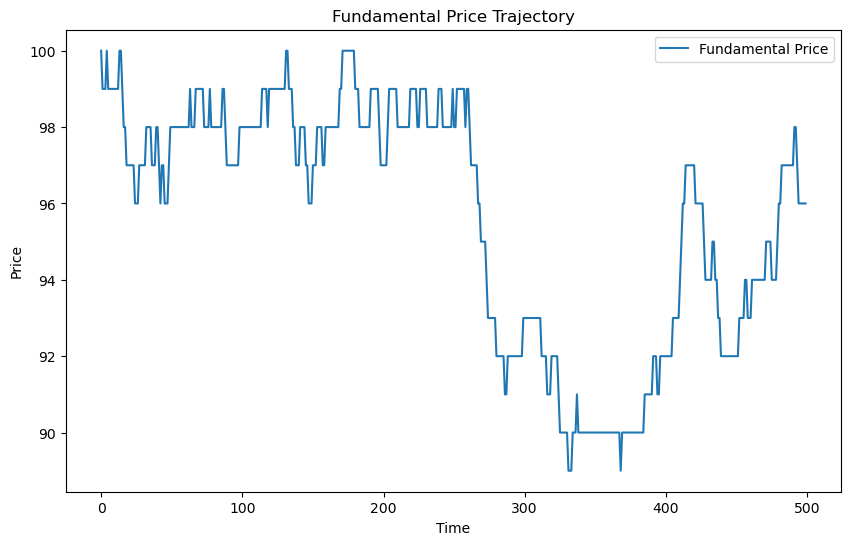

In [11]:
mkt.plot_single_fundamental_price()

In [22]:
print("The simulated dataframe for our Potential Fundamental Prices")
mkt.multiple_fundamental_price_sim(Nsim=10)

The simulated dataframe for our Potential Fundamental Prices


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,99.0,99.0,99.0,99.0,99.0,99.0,100.0,100.0,101.0,101.0
1,100.0,100.0,100.0,100.0,100.0,100.0,101.0,101.0,101.0,101.0,...,91.0,91.0,91.0,91.0,91.0,91.0,91.0,91.0,90.0,90.0
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,101.0,101.0,100.0,...,101.0,101.0,101.0,101.0,101.0,101.0,101.0,102.0,101.0,101.0
3,100.0,100.0,100.0,101.0,101.0,101.0,101.0,100.0,100.0,100.0,...,109.0,109.0,109.0,109.0,110.0,110.0,110.0,110.0,110.0,111.0
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,101.0,101.0,101.0,...,105.0,105.0,105.0,105.0,105.0,105.0,105.0,106.0,106.0,106.0
5,100.0,100.0,100.0,100.0,99.0,99.0,99.0,99.0,99.0,99.0,...,76.0,75.0,75.0,75.0,75.0,75.0,75.0,75.0,76.0,76.0
6,100.0,100.0,100.0,101.0,101.0,101.0,102.0,102.0,102.0,102.0,...,105.0,105.0,105.0,105.0,105.0,105.0,105.0,106.0,106.0,106.0
7,100.0,101.0,101.0,101.0,100.0,100.0,101.0,101.0,101.0,102.0,...,101.0,101.0,100.0,100.0,100.0,101.0,101.0,101.0,101.0,101.0
8,100.0,99.0,100.0,100.0,100.0,100.0,101.0,100.0,100.0,100.0,...,96.0,96.0,97.0,97.0,97.0,97.0,98.0,98.0,98.0,98.0
9,100.0,100.0,100.0,100.0,101.0,102.0,101.0,101.0,102.0,102.0,...,107.0,107.0,107.0,108.0,108.0,108.0,109.0,109.0,109.0,109.0


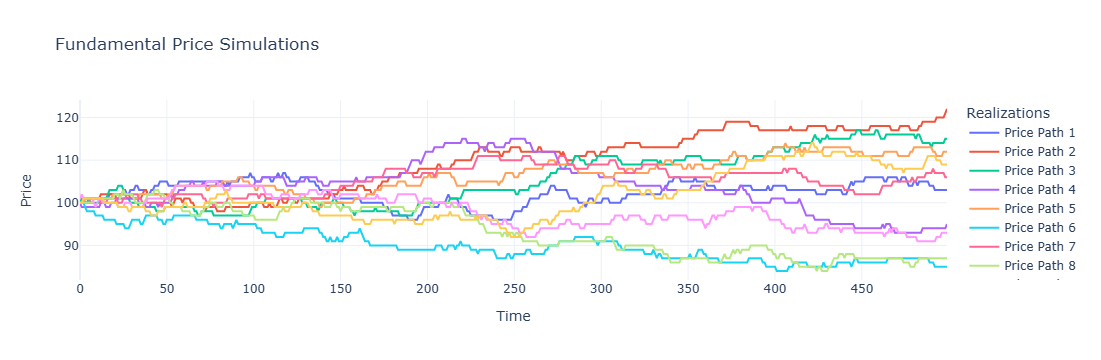

In [28]:
mkt.plot_simulations(Nsim=10)


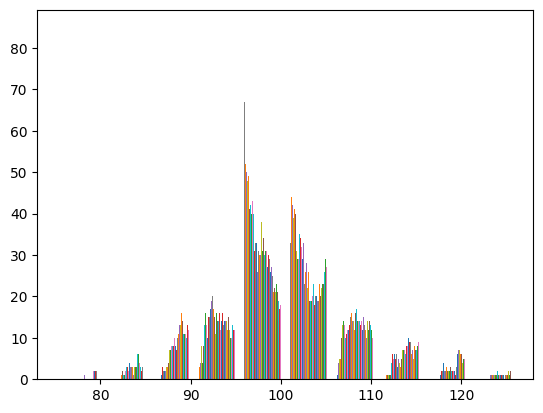

In [29]:
mkt.plot_fundamental_prices_distribution(Nsim=100)

In [30]:
print("Our Simulated Uninformed Orders")
mkt.simulate_uninformed_orders()

Our Simulated Uninformed Orders


array([-1.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  1.,
        0.,  0., -1.,  1.,  0.,  1.,  0.,  0.,  1., -1.,  0.,  1.,  1.,
        1.,  1.,  0., -1.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,
       -1.,  0.,  0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        1., -1.,  0., -1., -1.,  0.,  1., -1.,  0.,  0.,  1.,  0., -1.,
        1., -1., -1.,  0.,  1.,  1.,  0., -1.,  0.,  0., -1.,  0.,  0.,
        0., -1., -1.,  1., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0.,
       -1.,  1.,  1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  1.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  1., -1.,
        0.,  0.,  1.,  0.,  1., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0

In [32]:
print("Our Simulated Uninformed Orders Imbalance")
mkt.uniformed_orders_imbalance()

Our Simulated Uninformed Orders Imbalance


array([ 0.,  0.,  0.,  0.,  0., -1., -2., -2., -2., -1., -2., -2., -2.,
       -2., -3., -3., -3., -2., -2., -1.,  0.,  0.,  1.,  1.,  2.,  2.,
        2.,  3.,  2.,  3.,  3.,  2.,  3.,  2.,  2.,  3.,  2.,  2.,  2.,
        2.,  2.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  2.,  3.,
        3.,  2.,  1.,  1.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,
        3.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  6.,  5.,  4.,  4.,  4.,
        5.,  5.,  6.,  6.,  5.,  5.,  5.,  5.,  4.,  4.,  4.,  5.,  4.,
        4.,  5.,  5.,  5.,  6.,  5.,  4.,  3.,  2.,  3.,  3.,  3.,  2.,
        2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,  0.,  0.,
        0.,  0.,  0., -1., -2., -2., -1., -1.,  0.,  0., -1., -2., -3.,
       -3., -2., -2., -1.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  1.,  0.,  1.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  4.,  4.,  3.,  4.,  4.,
        4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  6

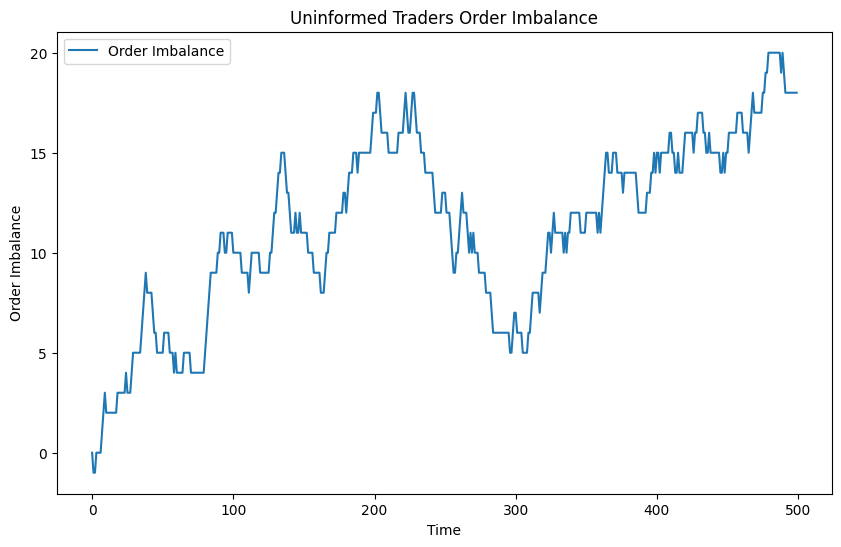

In [32]:
mkt.plot_uniformed_orders_imbalance()

### A simple market-making strategy

Initially we consider a very simple policy for our market-making agent. The policy $π_h$ is parameterised by a single threshold parameter $h$.
- Increase the price by a single tick if the order-imbalance is +h.
- Decrease the price by a single tick if the order-imbalance is −h.

Below the results in terms of simulated Order Imbalances, Rewards and Price Action (Fundamental vs Marker Maker price).

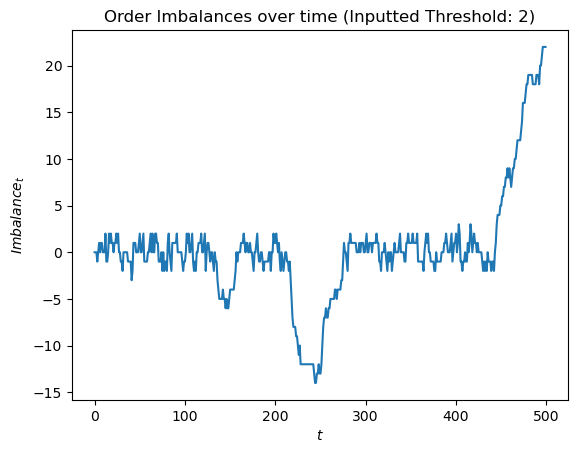

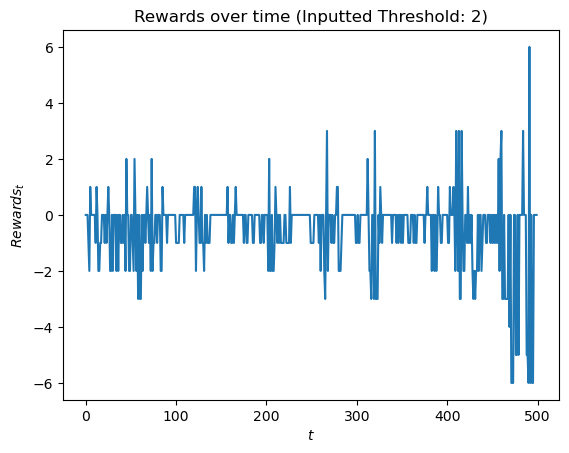

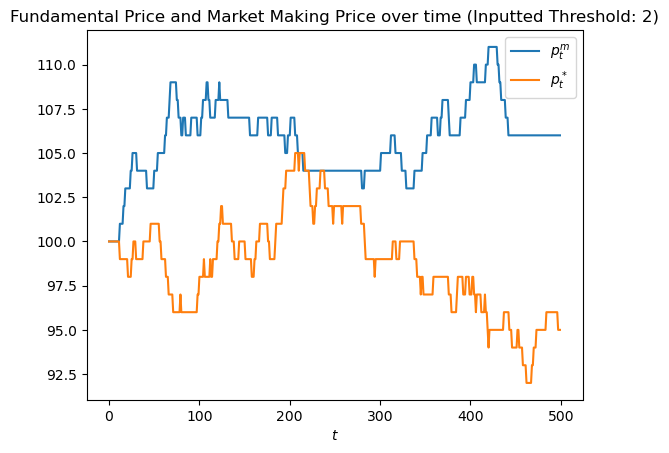

In [42]:
mkt.plot_order_imb_price_and_rewards(threshold=2)

### Policy evaluation

Now after various runs, we would like to identify the optimal market making policy. Each value of the threshold parameter h defines a policy $π_h$.

In the experiments above we set $h = 2$. We can estimate the expected reward, and hence the expected return, across the episode. 

With no time-discounting, i.e. $γ = 1$, the return $G$ is approximately:

In [44]:
mm_prices, order_imbalances, rewards, actions = mkt.simulate_market(threshold=1)
maxT = 500
print(np.mean(rewards)*maxT)

-1646.0


We could use this as an estimate of the expected return to the policy $\mathbb{E}(G)$.

However, we have only used a single sample.

We could try different strategies with different thresholds.

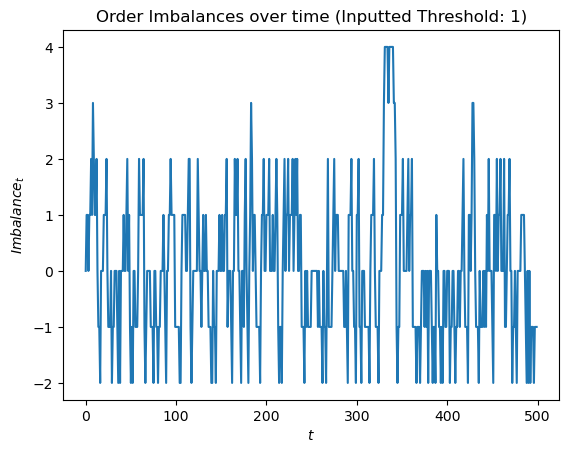

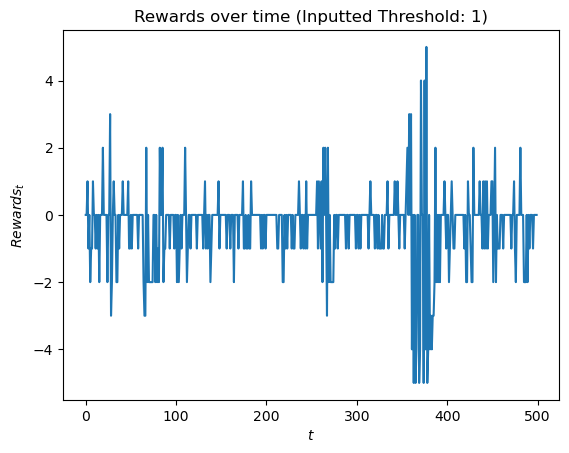

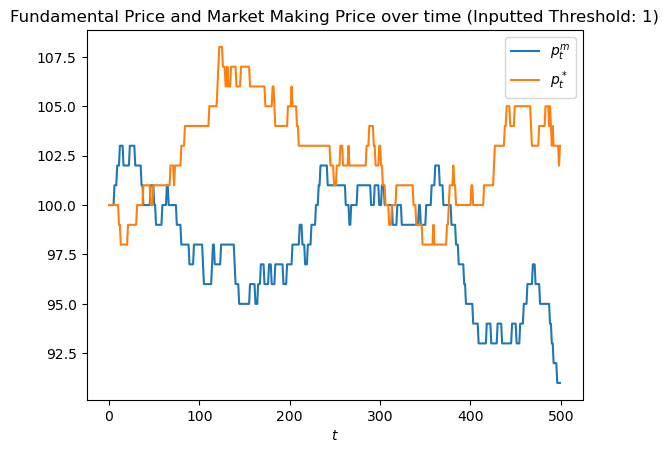

In [50]:
mkt.plot_order_imb_price_and_rewards(threshold=1)

#### Monte-carlo policy evaluation

We will attempt to obtain more accurate value estimates using a Monte-Carlo estimation approach.
- First we restructure our code so that we can easily rerun an entire simulation with given
parameters.


Using the sample-mean to estimate expected value:
- We realise the model many times.
- Each realisation is a single episode or trajectory.
- We can consider each episode as a sample.
- We use the sample mean as the best estimator for the expectation.


Last, we compare policies to find the optimal one.







In [52]:
print(mkt.evaluate_policy(threshold=2))

24.61058


In [54]:
print(mkt.evaluate_policy(threshold=1))

24.897874999999996


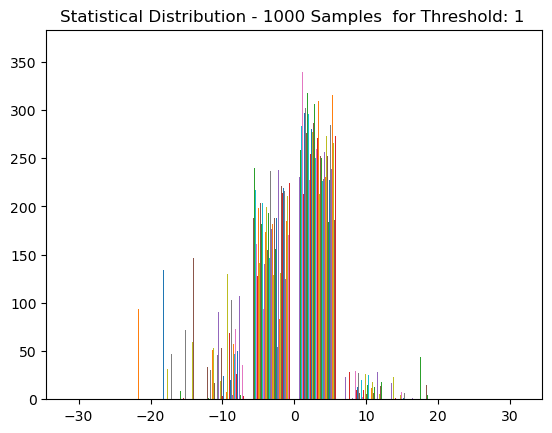

In [56]:
mkt.evaluate_policy_stat_distribution(threshold=1, samples=1000)

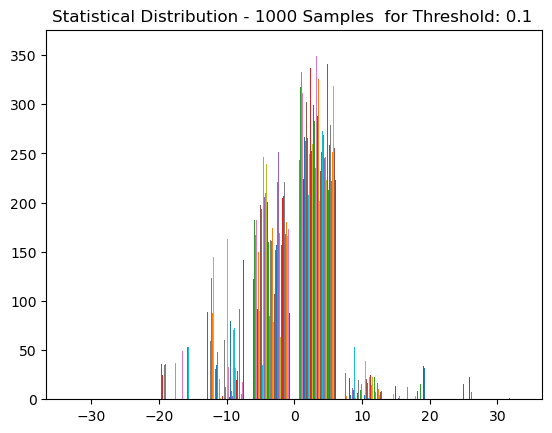

In [57]:
mkt.evaluate_policy_stat_distribution(threshold=0.1, samples=1000)

#### Policy improvement

We have estimated $Qπ(s, a) =  vπ(s, a) ∀s ∈ S ∀a ∈ A ∀ π$

If our estimates are accurate, we can use the function Q to find a better policy. To improve the policy we can simply take the greedy action for a given state:

$π′(s) = argmax_a Q_π(s, a)$

For the corresponding proof, see the policy improvement theorem.

#### Policy iteration

Note, however, that if we change the policy from π to π′, that our value estimates are outdated.
- Value estimates $Q_π(s, a)$ are obtained from following a given policy $π$.
- Value estimates and policies are not independent of each other.
- Therefore we should re-estimate $Q_{π′} (s, a)$ for the new policy as $v_{π′} (s, a)$
- We iterate until the policy and value estimates converge0

##### Temporal-difference (TD) learning
In the context of Reinforcement Learning, recall that:

$v_π(s) = \mathbb{E}_π[G_t|s_t = s]$

$= \mathbb{E}_π[r_{t+1} + γG_{t+1}|s_t = s]$

$= \mathbb{E}_π[r_{t+1} + γv_π(s_{t+1})|s_t = s] $

- When we use Monte-Carlo methods, $G_t$ is unknown, so we estimate Gt from sampled returns.
- When we use dynamic-programming $v_π(s_{t+1})$ is unknown, so we use our existing estimate $v_π(s_{t+1}) = V(s_{t+1})$ instead.
- Temporal difference learning combines both estimates:

$V(s) ← V(s) + α[r_t + γV(s_{t+1}) − V(s_t)]$

We can generalise this to $Q$:

$Q(s_t, a_t) ← Q(s_t, a_t) + α[r_t + γQ(s_{t+1}, a_{t+1}) − Q(s_t, a_t)]$

We could then develop a learning method for our market-making model to better identify the threshold to opt in a dynamic fashion. 

##### Conclusion

We have implemented a very simple market-making strategy in a simplified model of a financial market. The framework is very flexible, and can be extended to more realistic applications, e.g. separate bid and ask qutes. We can also use a simulation model to initially train our agent. However, the agent can learn directly from the environment in the absence of a model. Reinforcement-learning can be very useful in reducing model-risk.